# Pinot Noir Wine Review Naive Bayes Classifier

This notebook uses a Naive Bayes Classifier available from NLTK. Below are the packages needed to run this notebook. The text in the `reviews` field was cleaned in the notebook {insert name of .ipynb}. 

I would like to expand this classifier to be able to classify one of the top 3 varietals, but I chose due to time constraints to limit the scope to just **'Pinot Noir'**

**Data set source:**  I downloaded an existing data set from Maven Analytics.  The data was collected from the Wine Enthusiast magazine for the year 2017.

**Data set description:**  The data is wine reviews by sommeliers which include the taster's name, wine price, variety of wine, a score for the wine, country wine is from, the vineyard, taster's Twitter handle, and of course the taster's description of the wine.  It has 14 columns and just under 130,000 rows.

**Inspiration:** Zack Thoutt is the original scraper of this information from winemag.com. His process and his data were my inspiration. His github is here. Disclaimer: I used Zack's data, but I did not refer to his code for any of my analysis.

In [1]:
import pandas as pd
from nltk.probability import FreqDist
import numpy as np
import re
import nltk
from collections import Counter
from nltk.stem import PorterStemmer
import itertools
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

In [2]:
df = pd.read_csv("wine_BlobSent2.csv", index_col='id', na_filter=False)
df.head()

,description,points,variety,lowercase,no_punct,notstop,polarity,subjectivity,adjectives
id,,,,,,,,,
0,"Aromas include tropical fruit, broom, brimston...",87,White Blend,"aromas include tropical fruit, broom, brimston...",aromas include tropical fruit broom brimston...,aromas include tropical fruit broom brimstone ...,0.133,0.733,"['tropical', 'expressive', 'unripened', 'brisk']"
1,"This is ripe and fruity, a wine that is smooth...",87,Portuguese Red,"this is ripe and fruity, a wine that is smooth...",this is ripe and fruity a wine that is smooth...,ripe fruity wine smooth still structured firm ...,0.220,0.460,"['ripe', 'smooth', 'firm', 'juicy', 'red', 'dr..."
2,"Tart and snappy, the flavors of lime flesh and...",87,Pinot Gris,"tart and snappy, the flavors of lime flesh and...",tart and snappy the flavors of lime flesh and...,tart snappy flavors lime flesh rind dominate g...,0.025,0.358,"['tart', 'snappy', 'green', 'crisp', 'stainles..."
3,"Pineapple rind, lemon pith and orange blossom ...",87,Riesling,"pineapple rind, lemon pith and orange blossom ...",pineapple rind lemon pith and orange blossom ...,pineapple rind lemon pith orange blossom start...,0.167,0.167,"['opulent', 'astringent', 'semidry']"
4,"Much like the regular bottling from 2012, this...",87,Pinot Noir,"much like the regular bottling from 2012, this...",much like the regular bottling from 2012 this...,much like regular bottling 2012 comes across r...,0.307,0.449,"['regular', 'rough', 'tannic', 'rustic', 'eart..."


There are a few columns still in our dataframe from our cleaning and sentiment analysis notebook. Let's take a moment to remove some unnecessary columns, allowing us a more concise picture of the data we are working with.

In [3]:
del df['lowercase']
del df['no_punct']
del df['polarity']
del df['subjectivity']
df.head()

,description,points,variety,notstop,adjectives
id,,,,,
0,"Aromas include tropical fruit, broom, brimston...",87,White Blend,aromas include tropical fruit broom brimstone ...,"['tropical', 'expressive', 'unripened', 'brisk']"
1,"This is ripe and fruity, a wine that is smooth...",87,Portuguese Red,ripe fruity wine smooth still structured firm ...,"['ripe', 'smooth', 'firm', 'juicy', 'red', 'dr..."
2,"Tart and snappy, the flavors of lime flesh and...",87,Pinot Gris,tart snappy flavors lime flesh rind dominate g...,"['tart', 'snappy', 'green', 'crisp', 'stainles..."
3,"Pineapple rind, lemon pith and orange blossom ...",87,Riesling,pineapple rind lemon pith orange blossom start...,"['opulent', 'astringent', 'semidry']"
4,"Much like the regular bottling from 2012, this...",87,Pinot Noir,much like regular bottling 2012 comes across r...,"['regular', 'rough', 'tannic', 'rustic', 'eart..."


Taking a quick look at our varietal breakdown, we can see Pinot Noir is the top reviewed varietal, with Chardonnay close behind. There are a mindblowing 708 different varietals (or varietal blends) that have been reviewied in this dataset.

In [4]:
df['variety'].value_counts()

Pinot Noir                  13272
Chardonnay                  11753
Cabernet Sauvignon           9472
Red Blend                    8946
Bordeaux-style Red Blend     6915
                            ...  
Forcallà                        1
Favorita                        1
Catalanesca                     1
St. Vincent                     1
                                1
Name: variety, Length: 708, dtype: int64

In this next cell we just take a quick look at what a data frame with only Pinot Noir has in it.

In [5]:
wines = ['Pinot Noir']#, 'Chardonnay']
df_pinot = df.loc[df['variety'].isin(wines)]
df_pinot.head()

,description,points,variety,notstop,adjectives
id,,,,,
4,"Much like the regular bottling from 2012, this...",87,Pinot Noir,much like regular bottling 2012 comes across r...,"['regular', 'rough', 'tannic', 'rustic', 'eart..."
21,"A sleek mix of tart berry, stem and herb, alon...",87,Pinot Noir,sleek mix tart berry stem herb along hint oak ...,"['sleek', 'tart', 'fair', 'available', 'neutra..."
25,Oak and earth intermingle around robust aromas...,87,Pinot Noir,oak earth intermingle around robust aromas wet...,"['robust', 'wet', 'high', 'small', 'intense', ..."
35,As with many of the Erath 2010 vineyard design...,86,Pinot Noir,many erath 2010 vineyard designates strongly h...,"['many', 'herbal', 'unripe', 'sweet']"
41,"A stiff, tannic wine, this slowly opens and br...",86,Pinot Noir,stiff tannic wine slowly opens brings brambly ...,"['stiff', 'tannic', 'berry', 'earthy']"


### Here we will begin to prepare our data for the Naive Bayes Classifier

First thing first is to tokenize our column `notstop`. The `notstop` column contains each review text with text normalization techniques applied, such as lowercase casting, removal of non-alpha, punctuation, and leading and trailing whitespace.

In [6]:
#All wine reviews are tokenized.
df['wine_tokens'] = df['notstop'].apply(nltk.word_tokenize)

Let's stem our words in `wine_tokens` using PorterStemmer via NLTK to create a more concise corpus

In [7]:
stemmer = PorterStemmer()
 
df['stem_tokens'] = df['wine_tokens'].apply(lambda x: [stemmer.stem(y) for y in x])

One more quick look at our dataframe with stemmed wine review tokens

In [8]:
df.head()

,description,points,variety,notstop,adjectives,wine_tokens,stem_tokens
id,,,,,,,
0,"Aromas include tropical fruit, broom, brimston...",87,White Blend,aromas include tropical fruit broom brimstone ...,"['tropical', 'expressive', 'unripened', 'brisk']","[aromas, include, tropical, fruit, broom, brim...","[aroma, includ, tropic, fruit, broom, brimston..."
1,"This is ripe and fruity, a wine that is smooth...",87,Portuguese Red,ripe fruity wine smooth still structured firm ...,"['ripe', 'smooth', 'firm', 'juicy', 'red', 'dr...","[ripe, fruity, wine, smooth, still, structured...","[ripe, fruiti, wine, smooth, still, structur, ..."
2,"Tart and snappy, the flavors of lime flesh and...",87,Pinot Gris,tart snappy flavors lime flesh rind dominate g...,"['tart', 'snappy', 'green', 'crisp', 'stainles...","[tart, snappy, flavors, lime, flesh, rind, dom...","[tart, snappi, flavor, lime, flesh, rind, domi..."
3,"Pineapple rind, lemon pith and orange blossom ...",87,Riesling,pineapple rind lemon pith orange blossom start...,"['opulent', 'astringent', 'semidry']","[pineapple, rind, lemon, pith, orange, blossom...","[pineappl, rind, lemon, pith, orang, blossom, ..."
4,"Much like the regular bottling from 2012, this...",87,Pinot Noir,much like regular bottling 2012 comes across r...,"['regular', 'rough', 'tannic', 'rustic', 'eart...","[much, like, regular, bottling, 2012, comes, a...","[much, like, regular, bottl, 2012, come, acros..."


# Build a Pinot Noir Wine Review Naive Bayes Classifier

Currently our wine varietals are currently in string format. In order to build a Naive Bayes classifier, we must assign to a binary state for analysis. In this next cell we simply create a new column `label` that gives a row value of 1 if the wine varietal is 'Pinot Noir', otherwise, the row value gets 0

In [9]:
df['label'] = df['variety'].apply(lambda x: 1 if x=='Pinot Noir' else 0)

In the next cell we have to take our `stem_tokens` and vectorize into single-space separated strings (in each row)

In [10]:
df['vectorized'] = df['stem_tokens'].apply(lambda x: ' '.join(x))

count_vect = CountVectorizer()
counts = count_vect.fit_transform(df['vectorized'])

Next we use TfidTransformer to get a term frequency matrix times the inverse document-frequency.

In [11]:
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer().fit(counts) 
counts = transformer.transform(counts)

Initially I was creating a training and testing dataset manually. Then I learned about the module available in the scikit model that does this for you. The code that is commented out in the next cell is my hard coding of testing and training data. I used 10% but as much as 20% of the data could be set aside for testing.

In [12]:
# # Split data into train and test
# train_size = int(len(df_pinot) * .8)
# print ("Train size: %d" % train_size)
# print ("Test size: %d" % (len(df_pinot) - train_size))

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(counts, df['label'], test_size=0.3, random_state=47)

Now for the fun stuff! We get to train and test out our model for categorizing wine reviews based on Naive Bayes classification. For this model we are only looking to identify Pinot Noir specifically, but this classifier could be expanded to classify at least the top 3 varietals as they each have almost or more than 10,000 total reviews a piece.:

    Top 3 Varietals and Review Counts:
    
Pinot Noir    -->              13272

Chardonnay       -->           11753

Cabernet Sauvignon     -->      9472


In [13]:
from sklearn.naive_bayes import MultinomialNB

naive_bayes = MultinomialNB() #create naive_bayes variable
model = naive_bayes.fit(X_train, y_train) #fit our training data and assign to 'model' variable
predictions = model.predict(X_test) #use our model to test with our X_test data 

A lot of handwaving occured in the previous cell, but essentially we used the 'MultinomialNB()' classifier from NLTK that handles a lot of the heavy lifting for us. By calling this module on our training data, `X_train` and `y_train`, we are able to then use that model and make predictions on our `X_test` testing data.

In the following cell we use another nice few modules from scikit that allow us to easily calculate the Accuracy, Precision, and Recall of our model. Looks like we did pretty well, with an accuracy score above **90%**, a precision score above **92%** and a recall score of **11%**.

In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print('Accuracy score: ', accuracy_score(y_test, predictions))
print('Precision score: ', precision_score(y_test, predictions))
print('Recall score: ', recall_score(y_test, predictions))

Accuracy score:  0.9062884694296266
Precision score:  0.9363636363636364
Recall score:  0.07838660578386605


Looking at our results in a confusion matrix gives some idea of the shape of our results.

In [15]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, predictions))

[[35029    21]
 [ 3633   309]]


Text(90.77375, 0.5, 'predicted label')

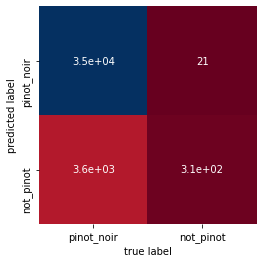

In [17]:
from sklearn.metrics import confusion_matrix
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, square=True, annot=True, cmap='RdBu', cbar=False, cbar_ax=True,
xticklabels=['pinot_noir', 'not_pinot'], yticklabels=['pinot_noir', 'not_pinot'])
plt.xlabel('true label')
plt.ylabel('predicted label')